<b><u>Observations</b></u>
<p>1. My data is skewed towards cities in the northern hemisphere (i.e., positive latitudes).  This isn't unusual since the vast majority of the global population is above the equater, but it's clear that there are way more dots on the right hand side of each chart than the left hand side.</p>
<p>2. In looking around +50 degrees latitude, there is a cluster of cities with ~70-90% humidity.  Outside of that, humidity levels were fairly dispersed across cities.</p>
<p>3. The trend for humidity described above is also similar for wind speed.  There is a bunch of of cities around +50 degrees latitude that have a wind speed between 0-10 mph.  There doesn't seem to be an obvious pattern for cities below +50 degrees latitude.</p>

I'm curious to see what trends would emerge if I used a much larger sample size or if I ran this script a few dozen times and compared the results.</p>

In [9]:
# Dependencies
import numpy as np
import random
import json
import requests
from pprint import pprint
from config import api_key
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

# Wrapper for OpenWeatherMap
# Will use this to view sample JSON API response
import openweathermapy.core as owm

# Dependencies for downloading and uncompressing list of cities from OpenWeatherMap
import urllib.request
import gzip

# Set the seaborn chart style
sns.set()

# Increase the size of the scatter plots
plt.rcParams["figure.figsize"] = [10,8]

# Store today's date
date = datetime.datetime.now().strftime("%m-%d-%Y")

In [2]:
# Print out a sample JSON API response
settings = {"units": "imperial", "appid": api_key}
pprint(owm.get_current(2172797, **settings))

{'base': 'stations',
 'clouds': {'all': 75},
 'cod': 200,
 'coord': {'lat': -16.92, 'lon': 145.77},
 'dt': 1522231200,
 'id': 2172797,
 'main': {'humidity': 94,
          'pressure': 1009,
          'temp': 78.8,
          'temp_max': 78.8,
          'temp_min': 78.8},
 'name': 'Cairns',
 'sys': {'country': 'AU',
         'id': 8166,
         'message': 0.0039,
         'sunrise': 1522182131,
         'sunset': 1522225289,
         'type': 1},
 'visibility': 10000,
 'weather': [{'description': 'light intensity shower rain',
              'icon': '09n',
              'id': 520,
              'main': 'Rain'}],
 'wind': {'deg': 150, 'speed': 5.82}}


<h1>Download City List</h1>

In [3]:
# This section downloads the list of cities and IDs that OpenWeatherMap uses from their website
# Decided this was more efficient than creating a list of cities using citipy and 
#   latitudes/longitudes since OpenWeatherMap says results will be more accurate if you use IDs instead of names

# File names
city_index_zip_file = "city.list.json.gz"
city_index_json_file = 'city.list.json'

# Download file
urllib.request.urlretrieve ("http://bulk.openweathermap.org/sample/city.list.json.gz", city_index_zip_file)

# Uncompress gzip file to json
inF = gzip.open(city_index_zip_file, 'rb')
outF = open(city_index_json_file, 'wb')
outF.write(inF.read())
inF.close()
outF.close()

# Read json file into a dataframe
city_index_df = pd.read_json(city_index_json_file)

# Print top five rows
city_index_df.head()

,coord,country,id,name
0,"{'lon': 34.283333, 'lat': 44.549999}",UA,707860,Hurzuf
1,"{'lon': 37.666668, 'lat': 55.683334}",RU,519188,Novinki
2,"{'lon': 84.633331, 'lat': 28}",NP,1283378,GorkhÄ�
3,"{'lon': 76, 'lat': 29}",IN,1270260,State of HaryÄ�na
4,"{'lon': 33.900002, 'lat': 44.599998}",UA,708546,Holubynka


<h1>Generate City List</h1>

In [4]:
# This section selects 555 random cities from the above city index dataframe

# Start by creating an empty dataframe
random_city_df = pd.DataFrame(columns=['coord', 'country', 'id', 'name', 'lon', 'lat'])

# Set counter to zero for looping
counter = 0

# Set total number of random cities
total_cities = 555

# Loop while counter is less than number of cities
while counter < total_cities:
    
    # Pick a random row (must be length - 1 since row starts at 0)
    row = random.randint(0, len(city_index_df)-1)
    
    # If ID is already in the dataframe then do nothing and repeat loop
    if any(random_city_df.id == city_index_df['id'][row]):
        pass
    
    # If ID isn't in the dataframe then add that row to the dataframe, including latitude and longitude
    else:
        random_city_df.loc[counter] = city_index_df.iloc[row,:]
        random_city_df.lat[counter] = city_index_df['coord'][row]['lat']
        random_city_df.lon[counter] = city_index_df['coord'][row]['lon']
        counter = counter + 1
        
# Change latitude and longitude columns from object to float
random_city_df[['lat','lon']] = random_city_df[['lat','lon']].apply(pd.to_numeric)

<h1>Weather API Call</h1>

In [5]:
# This section does the API calls from OpenWeatherMap

# Create empty lists for temperature, humidity, cloudiness and windspeed
# This will get added to the dataframe of cities
city_temp_list = []
city_humidity_list = []
city_cloudiness_list = []
city_windspeed_list = []

# Loop through the total number of cities
for index in range(total_cities):
    
    # Print out 
    print(f"Request {index+1} of {total_cities}: {random_city_df['name'][index]}")
    
    # Create the URL
    url = "http://api.openweathermap.org/data/2.5/weather?APPID="+api_key+"&units=imperial&id="+str(random_city_df.id[index])
    
    # Print the URl but mask the api key
    print("http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id="+str(random_city_df.id[index]))

    # Do the API call
    response = requests.get(url)
    
    # Convert API response to JSON
    data = response.json()
    
    # Grab temperature, humidity, cloudiness and windspeed and add it to their respective list    
    city_temp_list.append(data['main']['temp'])
    city_humidity_list.append(data['main']['humidity'])
    city_cloudiness_list.append(data['clouds']['all'])
    city_windspeed_list.append(data['wind']['speed'])

# Add temperature, humidity, cloudiness and windspeed as a column in the dataframe
random_city_df['temp'] = city_temp_list
random_city_df['humidity'] = city_humidity_list
random_city_df['cloudiness'] = city_cloudiness_list
random_city_df['windspeed'] = city_windspeed_list

Request 1 of 555: Szydlowiec
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=757178
Request 2 of 555: Bennhausen
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2951024
Request 3 of 555: Mogosani
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=672955
Request 4 of 555: Hochfelden
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6291215
Request 5 of 555: Montiano
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3172700
Request 6 of 555: PrÃ©fecture de la Ouaka
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=236887
Request 7 of 555: Paiguano
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3877770
Request 8 of 555: Claviere
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3178550
Request 9 of 555: Thiel-sur-Acolin
http://api.openweathermap.org/data/2.5/weather?APPI

Request 73 of 555: Taruma
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3446718
Request 74 of 555: Tonala
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3981369
Request 75 of 555: Silver Ridge
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=4504131
Request 76 of 555: Vergigny
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2969926
Request 77 of 555: Bagamoyo
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=161290
Request 78 of 555: Wendisch Priborn
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6548394
Request 79 of 555: Firenze
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3176959
Request 80 of 555: Waverly
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=5014208
Request 81 of 555: Dudendorf
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&uni

Request 144 of 555: Aramoho
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2193863
Request 145 of 555: Mendi
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2090990
Request 146 of 555: Paltinoasa
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=671418
Request 147 of 555: Terriente
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3108132
Request 148 of 555: Long Beach
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=5801520
Request 149 of 555: SÃ¼leymanlar Mahallesi
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=749262
Request 150 of 555: Pfaffing
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=7872166
Request 151 of 555: Ajofrin
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2522299
Request 152 of 555: Navalpino
http://api.openweathermap.org/data/2.5/weather

Request 215 of 555: Taintrux
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6445760
Request 216 of 555: Carrigtwohill
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2965694
Request 217 of 555: FoixÃ 
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6534058
Request 218 of 555: Dangstetten
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2939040
Request 219 of 555: Gisborne
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2206854
Request 220 of 555: Marcignago
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6534983
Request 221 of 555: Watford District
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=7290569
Request 222 of 555: Fall River County
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=5764690
Request 223 of 555: Kostâ€™kovo
http://api.openweathermap.org/d

Request 286 of 555: Burg auf Fehmarn
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2941496
Request 287 of 555: Huiyaozi
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=1672222
Request 288 of 555: San Felipe Pueblo
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=5489545
Request 289 of 555: Bereznik
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=577240
Request 290 of 555: Sturgeon
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=5214576
Request 291 of 555: Bohinjska Bistrica
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3203808
Request 292 of 555: Dakota Dunes
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=5227180
Request 293 of 555: Shibata
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=1852607
Request 294 of 555: Linnenbach
http://api.openweathermap.or

Request 358 of 555: Kruckow
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6547839
Request 359 of 555: Valea Caselor
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=663849
Request 360 of 555: Ayutla
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3532506
Request 361 of 555: Srirampur
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=1348562
Request 362 of 555: Midland
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=5803357
Request 363 of 555: Avenue
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2177466
Request 364 of 555: Echem
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2933808
Request 365 of 555: Cortes de la Frontera
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2519198
Request 366 of 555: Durazno
http://api.openweathermap.org/data/2.5/weather?APPI

Request 429 of 555: Sigetec
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3190918
Request 430 of 555: Noisy-le-Grand
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6451999
Request 431 of 555: San Juan
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6621286
Request 432 of 555: Ashland
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=4232953
Request 433 of 555: Kleinelbersdorf
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2889476
Request 434 of 555: Raasdorf
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2768171
Request 435 of 555: Carapegua
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3439167
Request 436 of 555: Departamento del Alto ParanÃ¡
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3439440
Request 437 of 555: Cortandone
http://api.openweatherma

Request 500 of 555: Valle de Tabladillo
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6360936
Request 501 of 555: Virudunagar
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=1253113
Request 502 of 555: Talitay
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=1683818
Request 503 of 555: Panindicuaro de la Reforma
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3993519
Request 504 of 555: Lahti
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=649374
Request 505 of 555: Siegburg
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2832521
Request 506 of 555: Schwalmstadt
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2835345
Request 507 of 555: Carahue
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3896774
Request 508 of 555: San Pablo Etla
http://api.openweatherm

In [6]:
# Export city dataframe as CSV
random_city_df.to_csv("weather_data.csv", encoding='utf-8')

<h1>Print Charts</h1>

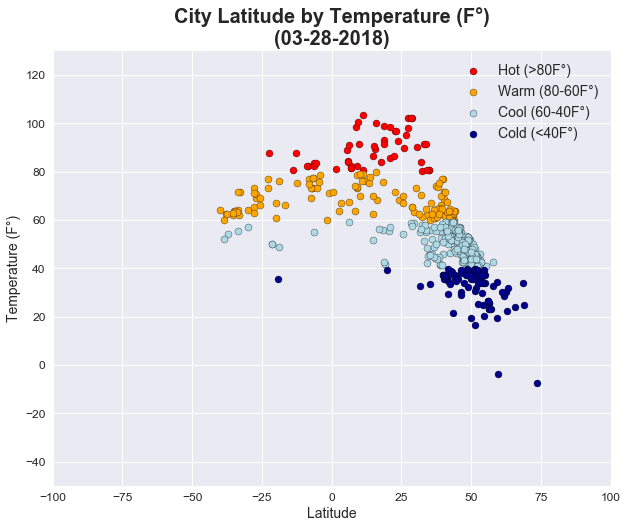

In [10]:
# This section prints a scatter plot of latitude by temperature

# Variables for hot, warm and cool cutoff tempatures
hot_temp = 80
warm_temp = 60
cold_temp = 40

# Create subsets of the dataframe to group by hot, warm, cool and cold temperatures
hot_cities = np.ma.masked_where((random_city_df['temp'] <= hot_temp), random_city_df['temp'])
warm_cities = np.ma.masked_where((random_city_df['temp'] > hot_temp) | (random_city_df['temp'] <= warm_temp), 
                                 random_city_df['temp'])
cool_cities = np.ma.masked_where((random_city_df['temp'] > warm_temp) | (random_city_df['temp'] <= cold_temp), random_city_df['temp'])
cold_cities = np.ma.masked_where((random_city_df['temp'] >= cold_temp), random_city_df['temp'])

# Clear the plot, just in case
plt.clf()

# Create scatter plots
plt.scatter(random_city_df['lat'], hot_cities, marker="o", facecolors='red', edgecolors="black", alpha=1)
plt.scatter(random_city_df['lat'], warm_cities, marker="o", facecolors='orange', edgecolors="black", alpha=1)
plt.scatter(random_city_df['lat'], cool_cities, marker="o", facecolors='lightblue', edgecolors="black", alpha=1)
plt.scatter(random_city_df['lat'], cold_cities, marker="o", facecolors='darkblue', edgecolors="black", alpha=1)

# Create a title, x label, and y label
plt.title(f"City Latitude by Temperature (F\N{DEGREE SIGN})\n({date})", fontsize=20, fontweight="bold")
plt.xlabel("Latitude", fontsize=14)
plt.ylabel("Temperature (F\N{DEGREE SIGN})", fontsize=14)

# Legend
plt.legend((f'Hot (>{hot_temp}F\N{DEGREE SIGN})',f'Warm ({hot_temp}-{warm_temp}F\N{DEGREE SIGN})', 
            f'Cool ({warm_temp}-{cold_temp}F\N{DEGREE SIGN})',f'Cold (<{cold_temp}F\N{DEGREE SIGN})'),loc='best', prop={'size': 14})

# Set size of x and y tick labels
plt.tick_params(labelsize=12)

# Set x and y limits
plt.xlim(-100,100)
plt.ylim(-50,130)

# Save the figure
plt.savefig("LatByTemp.png")

# Display scatter chart
plt.show()

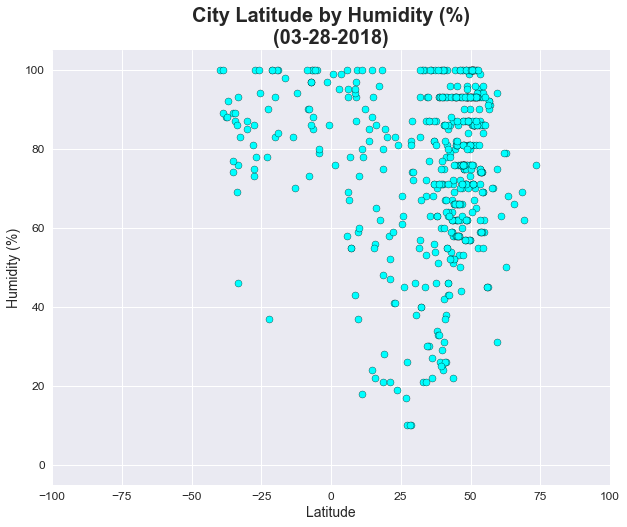

In [14]:
# This section prints a scatter plot of latitude by humidity

# Clear plot, just in case
plt.clf()

# Create scatter plot
plt.scatter(random_city_df['lat'], random_city_df['humidity'], marker="o", facecolors='aqua', edgecolors="black", alpha=1)

# Create a title, x label, and y label
plt.title(f"City Latitude by Humidity (%)\n({date})", fontsize=20, fontweight="bold")
plt.xlabel("Latitude", fontsize=14)
plt.ylabel("Humidity (%)", fontsize=14)

# Set size of x and y tick labels
plt.tick_params(labelsize=12)

# Set x and y limits
plt.xlim(-100,100)
plt.ylim(-5,105)

# Save the figure
plt.savefig("LatByHumidity.png")

# Display scatter chart
plt.show()

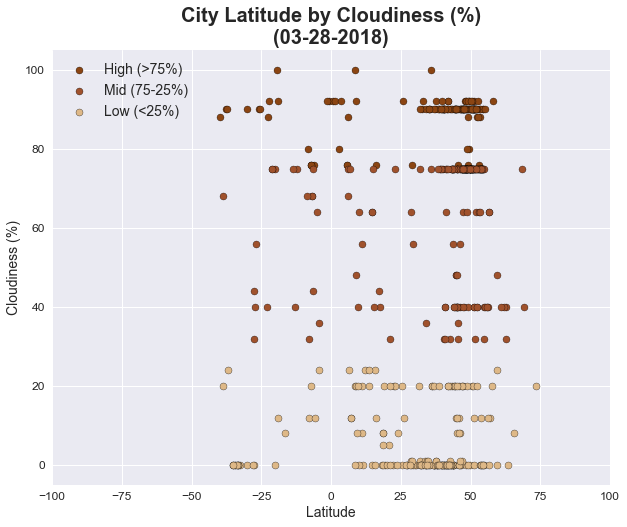

In [15]:
# This section prints a scatter plot of latitude by cloudiness

# Variables for high, mid and low cutoff levels of cloudiness
high_cloudiness = 75
low_cloudiness = 25

# Create subsets of the dataframe to group by migh, mid and low cloudiness
high_cloud_cities = np.ma.masked_where((random_city_df['cloudiness'] <= high_cloudiness), random_city_df['cloudiness'])
mid_cloud_cities = np.ma.masked_where((random_city_df['cloudiness'] > high_cloudiness) | 
                                      (random_city_df['cloudiness'] <= low_cloudiness), 
                                      random_city_df['cloudiness'])
low_cloud_cities = np.ma.masked_where((random_city_df['cloudiness'] >= low_cloudiness), random_city_df['cloudiness'])

# Clear plot, just in case
plt.clf()

# Create scatter plot
plt.scatter(random_city_df['lat'], high_cloud_cities, marker="o", facecolors='saddlebrown', edgecolors="black", alpha=1)
plt.scatter(random_city_df['lat'], mid_cloud_cities, marker="o", facecolors='sienna', edgecolors="black", alpha=1)
plt.scatter(random_city_df['lat'], low_cloud_cities, marker="o", facecolors='burlywood', edgecolors="black", alpha=1)

plt.legend((f'High (>{high_cloudiness}%)', f'Mid ({high_cloudiness}-{low_cloudiness}%)', 
            f'Low (<{low_cloudiness}%)'),loc='best', prop={'size': 14})

# Create a title, x label, and y label
plt.title(f"City Latitude by Cloudiness (%)\n({date})", fontsize=20, fontweight="bold")
plt.xlabel("Latitude", fontsize=14)
plt.ylabel("Cloudiness (%)", fontsize=14)

# Set size of x and y tick labels
plt.tick_params(labelsize=12)

# Set x and y limits
plt.xlim(-100,100)
plt.ylim(-5,105)

# Save the figure
plt.savefig("LatByCloudiness.png")

# Display scatter plot
plt.show()

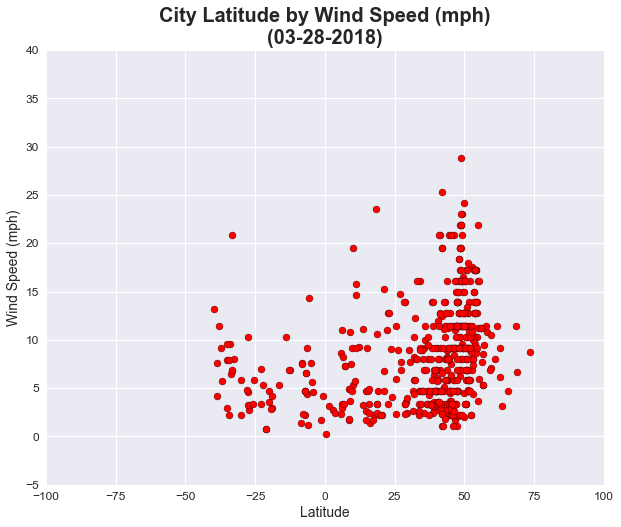

In [16]:
# This section prints a scatter plot of latitude by windspeed

# Clear plot, just in case
plt.clf()

# Create scatter plot
plt.scatter(random_city_df['lat'], random_city_df['windspeed'], marker="o", facecolors='red', edgecolors="black", alpha=1)

# Create a title, x label, and y label
plt.title(f"City Latitude by Wind Speed (mph)\n({date})", fontsize=20, fontweight="bold")
plt.xlabel("Latitude", fontsize=14)
plt.ylabel("Wind Speed (mph)", fontsize=14)

# Set size of x and y tick labels
plt.tick_params(labelsize=12)

# Set x and y limits
plt.xlim(-100,100)
plt.ylim(-5,40)

# Save the figure
plt.savefig("LatByWindspeed.png")

# Display scatter plot
plt.show()